In [3]:
ess_system_cycles = 35
ess_batery_health = [0.9858, 0.9743, 0.9648, 0.9570, 0.9504, 0.9446, 0.9396, 0.9351, 0.9311, 0.9274,
                         0.9239, 0.9206, 0.9175, 0.9144, 0.9115, 0.9115, 0.9115, 0.9115, 0.9115, 0.9115,
                         0.9115, 0.9115, 0.9115, 0.9115, 0.9115, 0.9115, 0.9115, 0.9115, 0.9115, 0.9115]
ess_demand_charge_savings = [13689, 13615, 13553, 13500, 13455, 13416, 13381, 13350, 13321, 13294,
                                 13269, 13245, 13222, 13199, 13178, 13178, 13178, 13178, 13178, 13178,
                                 13178, 13178, 13178, 13178, 13178, 13178, 13178, 13178, 13178, 13178]
pv_demand_charge_savings = [8645, 8602, 8559, 8516, 9474, 8431, 8389, 8347, 8305, 8264,
                                8223, 8181, 8141, 8100, 8059, 8059, 8059, 8059, 8059, 8059,
                                8059, 8059, 8059, 8059, 8059, 8059, 8059, 8059, 8059, 8059]

# EDA

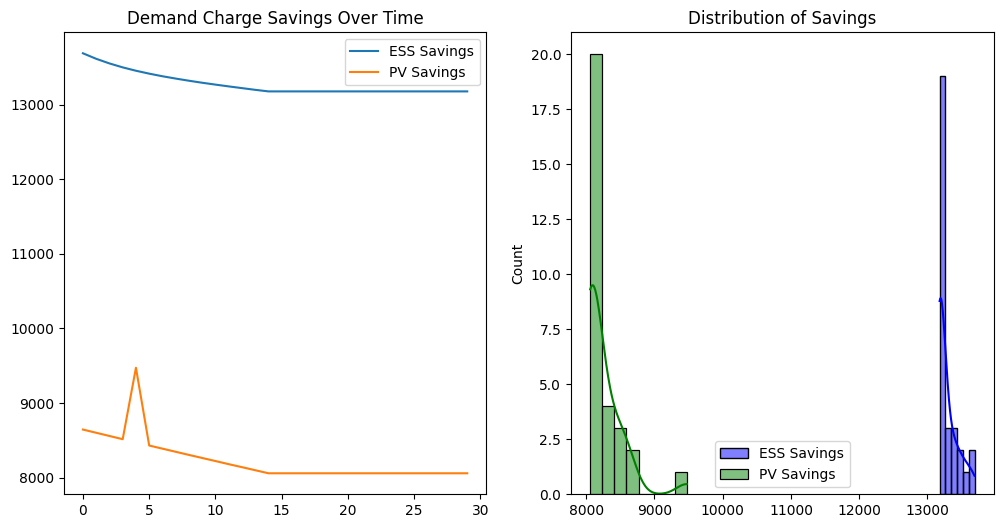

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制基本的线图和直方图
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ess_demand_charge_savings, label='ESS Savings')
plt.plot(pv_demand_charge_savings, label='PV Savings')
plt.title('Demand Charge Savings Over Time')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(ess_demand_charge_savings, kde=True, color='blue', label='ESS Savings')
sns.histplot(pv_demand_charge_savings, kde=True, color='green', label='PV Savings')
plt.title('Distribution of Savings')
plt.legend()

plt.show()

In [8]:
import numpy as np

# 计算 IQR 识别异常值
def detect_outliers(data):
    q25, q75 = np.percentile(data, 25), np.percentile(data, 75)
    iqr = q75 - q25
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    return outliers

ess_outliers = detect_outliers(ess_demand_charge_savings)
pv_outliers = detect_outliers(pv_demand_charge_savings)

print("ESS Outliers:", ess_outliers)
print("PV Outliers:", pv_outliers)

ESS Outliers: [13689, 13615]
PV Outliers: [9474]


## Linear Model

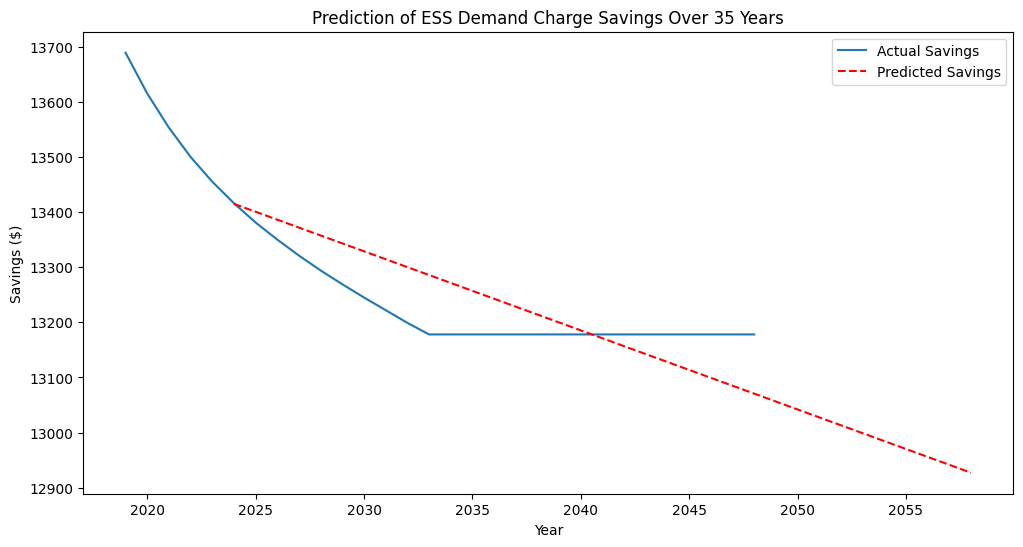

In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# 原始数据
years = np.arange(2019, 2019 + len(ess_demand_charge_savings)).reshape(-1, 1)
savings = np.array(ess_demand_charge_savings)

# 创建线性回归模型
model = LinearRegression()
model.fit(years, savings)

# 预测从2024年开始的未来35年的数据
future_years = np.arange(2024, 2024 + 35).reshape(-1, 1)
predicted_savings = model.predict(future_years)

# 绘图显示
plt.figure(figsize=(12, 6))
plt.plot(years, savings, label='Actual Savings')
plt.plot(future_years, predicted_savings, color='red', label='Predicted Savings', linestyle='--')
plt.title('Prediction of ESS Demand Charge Savings Over 35 Years')
plt.xlabel('Year')
plt.ylabel('Savings ($)')
plt.legend()
plt.show()

# Multinomial Regression Model

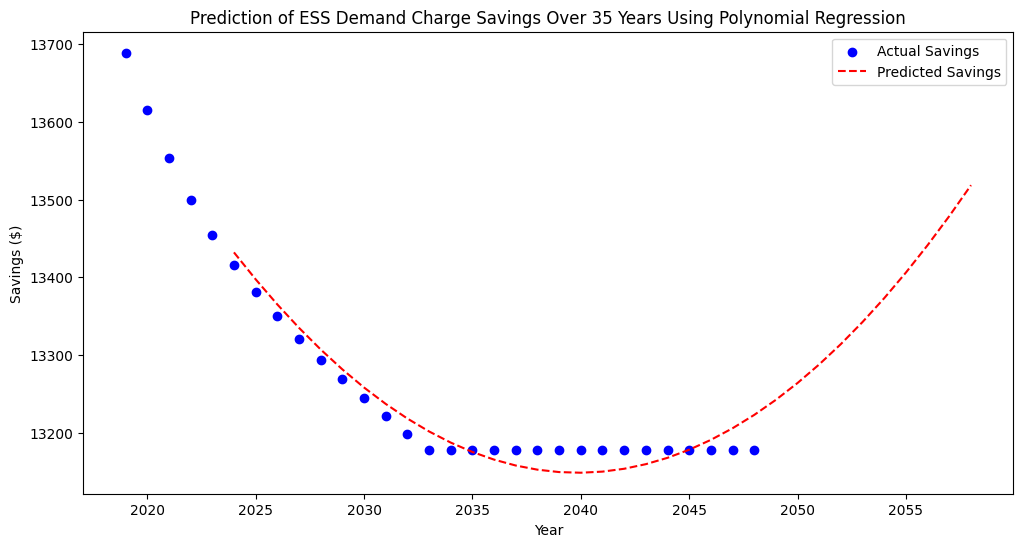

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# 原始数据
years = np.arange(2019, 2019 + len(ess_demand_charge_savings))  # 2019年至当前数据的年份
savings = np.array(ess_demand_charge_savings)

# 转换年份数据以适应多项式模型
years_reshaped = years.reshape(-1, 1)

# 创建多项式特征
poly_degree = 2  # 你可以调整这个参数来看不同多项式次数的效果
poly_features = PolynomialFeatures(degree=poly_degree)
x_poly = poly_features.fit_transform(years_reshaped)

# 创建线性回归模型并拟合转换后的多项式特征
model = LinearRegression()
model.fit(x_poly, savings)

# 预测从2024年开始的未来35年的数据
future_years = np.arange(2024, 2024 + 35).reshape(-1, 1)
future_years_poly = poly_features.transform(future_years)
predicted_savings = model.predict(future_years_poly)

# 绘图显示
plt.figure(figsize=(12, 6))
plt.scatter(years, savings, color='blue', label='Actual Savings')
plt.plot(future_years, predicted_savings, color='red', label='Predicted Savings', linestyle='--')
plt.title('Prediction of ESS Demand Charge Savings Over 35 Years Using Polynomial Regression')
plt.xlabel('Year')
plt.ylabel('Savings ($)')
plt.legend()
plt.show()

# Deep Learning

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
# 数据规范化
savings = np.array(ess_demand_charge_savings).reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_savings = scaler.fit_transform(savings)

# 创建数据集
def create_dataset(data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(data) - look_back):
        a = data[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3
dataX, dataY = create_dataset(scaled_savings, look_back)
dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))

In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=3, hidden_layer_size=100, output_size=1):  # 注意这里的改动
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [14]:
model = LSTMModel()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for i in range(epochs):
    for seq, labels in zip(dataX, dataY):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        
        y_pred = model(torch.tensor(seq, dtype=torch.float32))
        single_loss = loss_function(y_pred, torch.tensor(labels, dtype=torch.float32))
        single_loss.backward()
        optimizer.step()

    if i%25 == 0:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   0 loss: 0.01201873
epoch:  25 loss: 0.00008782


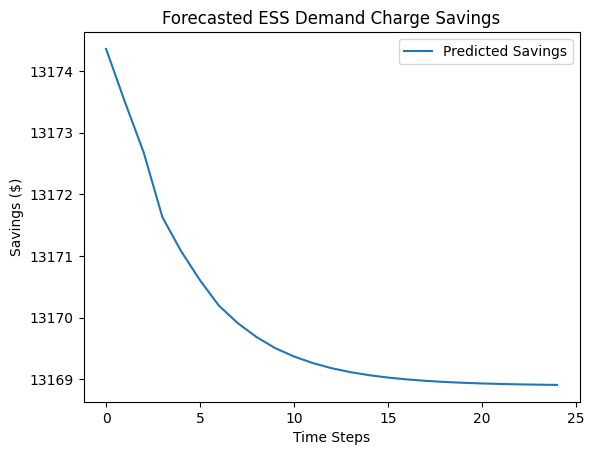

In [22]:
# Correct the sliding window update mechanism
model.eval()

# Initialize with the last 'look_back' sequences from the training data formatted as a numpy array
test_inputs = dataX[-1].reshape(1, -1)  # Ensure proper shape (1, look_back)

# Prepare for predictions
predicted_outputs = []  # To store the output predictions for plotting or analysis

for i in range(25):
    # Ensure the input is correctly shaped for the model
    seq_tensor = torch.tensor(test_inputs, dtype=torch.float32)

    with torch.no_grad():
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                             torch.zeros(1, 1, model.hidden_layer_size))
        prediction = model(seq_tensor).item()  # Make a prediction
        
    # Append the prediction to predicted_outputs
    predicted_outputs.append(prediction)

    # Update the test_inputs to include the new prediction and remove the oldest data point
    # This next line prepares the prediction in a shape (1, 1) so it can be appended to (1, look_back)
    new_data_point = np.array([[prediction]])
    test_inputs = np.append(test_inputs[:, 1:], new_data_point, axis=1)  # Slide the window correctly

# Convert predictions for visualization or other uses
predicted_savings = scaler.inverse_transform(np.array(predicted_outputs).reshape(-1, 1))

# Plotting
plt.plot()
plt.plot(range(len(predicted_savings)), predicted_savings, label="Predicted Savings")
plt.xlabel('Time Steps')
plt.ylabel('Savings ($)')
plt.title('Forecasted ESS Demand Charge Savings')
plt.legend()
plt.show()

In [23]:
predicted_savings

array([[13174.36176842],
       [13173.50383583],
       [13172.68236906],
       [13171.62880872],
       [13171.07414237],
       [13170.60487638],
       [13170.19503389],
       [13169.91139781],
       [13169.6841623 ],
       [13169.50312772],
       [13169.36711002],
       [13169.26045001],
       [13169.17727309],
       [13169.11332657],
       [13169.06356205],
       [13169.02494134],
       [13168.99506588],
       [13168.97187213],
       [13168.95389431],
       [13168.93996359],
       [13168.92916244],
       [13168.92078269],
       [13168.91429133],
       [13168.90925815],
       [13168.90535572]])